In [1]:
%matplotlib inline
import vgg
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import scipy.io
import scipy.misc
import math
from PIL import Image

In [2]:
def imread(path):
    img = scipy.misc.imread(path).astype(np.float)  # 처리 하기 전에 float형으로 바꿔준다
    if len(img.shape) == 2:
        # grayscale
        img = np.dstack((img,img,img))
    elif img.shape[2] == 4:
        # PNG with alpha channel
        img = img[:,:,:3]
    return img

def imsave(path, img):
    img = np.clip(img, 0, 255).astype(np.uint8)  # 이미지를 rgb 0~255 값으로 clipping 해준다
    Image.fromarray(img).save(path, quality=95)

In [3]:
def _tensor_size(tensor):
    from operator import mul
    return reduce(mul, (d.value for d in tensor.get_shape()), 1)

In [4]:
style   = imread('examples/style.jpg')
content = imread('examples/content.jpg')

(-0.5, 599.5, 398.5, -0.5)

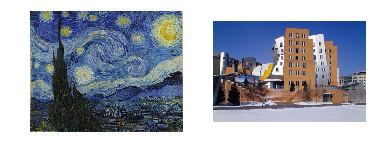

In [5]:
style_img   = style.astype(np.uint8)   # 이미지 타입을 바꿔준다음 출력한다
content_img = content.astype(np.uint8)

plt.subplot(1, 2, 1)
plt.imshow(style_img)
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(content_img)
plt.axis('off')

In [6]:
target_shape = content.shape

style = scipy.misc.imresize(style, target_shape[1] / float(style.shape[1]))

initial_noiseblend = 1.0
initial = content

/usr/lib/python2.7/dist-packages/scipy/misc/pilutil.py:479: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if issubdtype(ts, int):
/usr/lib/python2.7/dist-packages/scipy/misc/pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):


In [7]:
CONTENT_WEIGHT = 5e0
STYLE_WEIGHT = 5e2
TV_WEIGHT = 1e2

STYLE_LAYER_WEIGHT_EXP = 1

LEARNING_RATE = 1e1
BETA1 = 0.9
BETA2 = 0.999
EPSILON = 1e-08

ITERATIONS = 1000

POOLING = 'max'

In [8]:
from functools import reduce

CONTENT_LAYERS = ('relu4_2', 'relu5_2')
STYLE_LAYERS = ('relu1_1', 'relu2_1', 'relu3_1', 'relu4_1', 'relu5_1')

shape = (1,) + content.shape
style_shape = (1,) + style.shape

In [9]:
vgg_weights, vgg_mean_pixel = vgg.load_net('/media/dyros-data/pretrained_weights/imagenet-vgg-verydeep-19.mat')

In [10]:
layer_weight = 1.0
style_layers_weights = {}
for style_layer in STYLE_LAYERS:
    style_layers_weights[style_layer] = layer_weight
    layer_weight *= STYLE_LAYER_WEIGHT_EXP    
    
# normalize style layer weights
layer_weights_sum = 0
for style_layer in STYLE_LAYERS:
    layer_weights_sum += style_layers_weights[style_layer]
for style_layer in STYLE_LAYERS:
    style_layers_weights[style_layer] /= layer_weights_sum

In [11]:
# compute content features in feedforward mode
content_features = {}

g = tf.Graph()
with g.as_default(), g.device('/cpu:0'), tf.Session() as sess:
    image = tf.placeholder('float', shape=shape)
    net = vgg.net_preloaded(vgg_weights, image, POOLING)  # 기존의 vgg net을 갖다쓴다
    content_pre = np.array([vgg.preprocess(content, vgg_mean_pixel)])  # 입력으로 줄 이미지를 준비한다
    
    for layer in CONTENT_LAYERS:
        content_features[layer] = net[layer].eval(feed_dict={image: content_pre})  # network를 evaluation으로 각 콘텐츠의 feature를 뽑아낸다

In [12]:
# compute style features in feedforward mode
style_features = {}


# vggnet의 입력은 보통 224 x 224  for training
# 하지만 test는 아무개 x 아무개의 이미지가 들어올 수 있다
# 그런데 고흐의 그림은 픽셀이 정해져 있으므로 test 이미지와 다를 수 있다
# 따라서 고흐의 그림과 test 이미지를 비교할 수 있는 같은 차원의 activation map 행렬이 필요하다
# 따라서 자기끼리 (n,(r,c,)) x ((r,c,),n)  = n x n 행렬을 만드는 연산을 하는 것이다
g = tf.Graph()
with g.as_default(), g.device('/cpu:0'), tf.Session() as sess:
    image = tf.placeholder('float', shape=style_shape)
    net = vgg.net_preloaded(vgg_weights, image, POOLING)
    style_pre = np.array([vgg.preprocess(style, vgg_mean_pixel)])
    
    # style feature를 n x n 
    for layer in STYLE_LAYERS:
        features = net[layer].eval(feed_dict={image: style_pre})
        features = np.reshape(features, (-1, features.shape[3]))
        gram = np.matmul(features.T, features) / features.size
        style_features[layer] = gram

In [13]:
initial_content_noise_coeff = 1.0 - initial_noiseblend

In [14]:
initial = np.array([vgg.preprocess(initial, vgg_mean_pixel)])
initial = initial.astype(np.float32)
noise = np.random.normal(size=shape, scale=np.std(content) * 0.1)
initial = (initial) * initial_content_noise_coeff + (tf.random_normal(shape) * 0.256) * (1.0 - initial_content_noise_coeff)

image = tf.Variable(initial)
net = vgg.net_preloaded(vgg_weights, image, POOLING)

In [15]:
 # content loss     
 # 타겟사진의 특정 컨벌루션 지점에서 추출한 결과(activation map)와 
 # 합성물에서 중간에 추출한 결과가 얼마나 비슷한지를 loss fuction으로 하는듯
content_layers_weights = {}
content_layers_weights['relu4_2'] = 1.0
content_layers_weights['relu5_2'] = 1.0 - content_layers_weights['relu4_2']

content_loss = 0
content_losses = []
for content_layer in CONTENT_LAYERS:
    content_losses.append(content_layers_weights[content_layer] * CONTENT_WEIGHT * (2 * tf.nn.l2_loss(
            net[content_layer] - content_features[content_layer]) /
            content_features[content_layer].size))
content_loss += reduce(tf.add, content_losses)

In [16]:
# style loss
# 
style_loss = 0
style_losses = []
for style_layer in STYLE_LAYERS:
    layer = net[style_layer]
    _, height, width, number = map(lambda i: i.value, layer.get_shape())
    size = height * width * number
    feats = tf.reshape(layer, (-1, number))
    gram = tf.matmul(tf.transpose(feats), feats) / size
    style_gram = style_features[style_layer]
    style_losses.append(style_layers_weights[style_layer] * 2 * tf.nn.l2_loss(gram - style_gram) / style_gram.size)
style_loss += STYLE_WEIGHT * reduce(tf.add, style_losses)

In [17]:
# total variation denoising
tv_y_size = _tensor_size(image[:,1:,:,:])
tv_x_size = _tensor_size(image[:,:,1:,:])
tv_loss = TV_WEIGHT * 2 * (
        (tf.nn.l2_loss(image[:,1:,:,:] - image[:,:shape[1]-1,:,:]) / tv_y_size) +
        (tf.nn.l2_loss(image[:,:,1:,:] - image[:,:,:shape[2]-1,:]) / tv_x_size))

In [18]:
# overall loss
loss = content_loss + style_loss + tv_loss

# optimizer setup
train_step = tf.train.AdamOptimizer(LEARNING_RATE, BETA1, BETA2, EPSILON).minimize(loss)

In [19]:
# optimization
best_loss = float('inf')
best = None
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    print('Optimization started...')            
    for i in range(ITERATIONS):
        if i%100 == 0:
            print('Iteration %4d/%4d' % (i + 1, ITERATIONS))
        train_step.run()

        last_step = (i == ITERATIONS - 1)
        if last_step:
            print('  content loss: %g' % content_loss.eval())
            print('    style loss: %g' % style_loss.eval())
            print('       tv loss: %g' % tv_loss.eval())
            print('    total loss: %g' % loss.eval())

            this_loss = loss.eval()
            if this_loss < best_loss:
                best_loss = this_loss
                best = image.eval()

            img_out = vgg.unprocess(best.reshape(shape[1:]), vgg_mean_pixel)

Optimization started...
Iteration    1/1000
Iteration  101/1000
Iteration  201/1000
Iteration  301/1000
Iteration  401/1000
Iteration  501/1000
Iteration  601/1000
Iteration  701/1000
Iteration  801/1000
Iteration  901/1000
  content loss: 1.30912e+06
    style loss: 660710
       tv loss: 61882.8
    total loss: 2.03171e+06


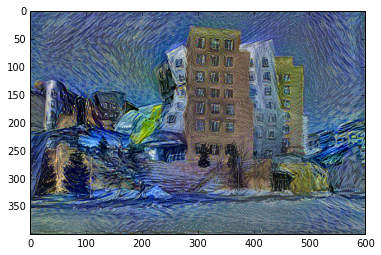

In [20]:
img = np.clip(img_out, 0, 255).astype(np.uint8)
plt.imshow(img)